In [1]:
# Essential Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling (optional, if needed later)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Date and time handling
from datetime import datetime

# Suppress warnings for cleaner output
import os
import warnings
warnings.filterwarnings("ignore")

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


In [14]:
# Define the Excel path (as used in your examples)
excel_path = r'data\Project Assessment Data.xlsx' 

# This df_lowercase dictionary will store the loaded sheets
df_lowercase = {} 

# Ensure the file path exists (this check would run in your local environment)
if not os.path.exists(excel_path):
    # In a local script, you might raise an error or print a message
    print(f"Warning: File not found at: {excel_path}. The script would fail here if run locally without the file.")
    # df_lowercase remains an empty dict
else:
    # Read all sheets and convert keys to lowercase
    # This is the core part for loading the Excel file
    print(f"Attempting to read Excel file: {excel_path}")
    df_dict = pd.read_excel(excel_path, sheet_name=None)
    df_lowercase = {sheet_name.lower(): df for sheet_name, df in df_dict.items()}
    print("Excel file sheets loaded into 'df_lowercase' dictionary.")

    # Preview first 2 rows for each sheet and create individual df variables
    print(f"\n--- Previewing Sheets from: {excel_path} and Creating Individual DataFrames ---")
    for sheet_key, df_value in df_lowercase.items(): # sheet_key is already lowercase
        print(f"\n📄 Sheet: {sheet_key} ({df_value.shape[0]} rows, {df_value.shape[1]} columns)")
        print(df_value.head(2))
        
        # --- Corrected part for creating individual DataFrame variables ---
        # Create a valid variable name, e.g., 'df_sheet name' becomes 'df_sheet_name'
        # The sheet_key is already lowercase. We just need to handle spaces or other special characters
        # if they are expected in sheet names (though Excel sheet names usually don't have many).
        variable_name = 'df_' + sheet_key.replace(' ', '_').replace('-', '_')
        
        # Assign the current sheet's DataFrame (df_value) to the new global variable
        globals()[variable_name] = df_value
        print(f"   -> Created DataFrame variable: {variable_name}")
        # --- End of corrected part ---
        
    print("-" * 60)


# --- Verification (optional, to check if variables were created) ---
# This part would run after the loop above.
if df_lowercase: # Only try to verify if df_lowercase was populated
    print("\n--- Verifying created DataFrame variables (example) ---")
    # Example: if you had a sheet named 'qmel' in your Excel file
    if 'df_qmel' in globals():
        print("Successfully created 'df_qmel'. Head:")
        print(globals()['df_qmel'].head(1))
    else:
        # Check for a key that might exist in df_lowercase to give a more specific message
        example_key_to_check = None
        if 'qmel' in df_lowercase: # if 'qmel' was a sheet name
             example_key_to_check = 'qmel'
        elif df_lowercase.keys(): # take the first available key if 'qmel' isn't there
            example_key_to_check = list(df_lowercase.keys())[0]

        if example_key_to_check:
            expected_var_name = 'df_' + example_key_to_check.replace(' ', '_').replace('-', '_')
            print(f"Variable 'df_qmel' (or similar like '{expected_var_name}') not found in globals.")
            print(f"Make sure a sheet corresponding to it existed and was loaded correctly.")
        else:
            print("No sheets were loaded into df_lowercase to verify variable creation.")
else:
    print("\n'df_lowercase' is empty. No DataFrames were created or verified.")

Attempting to read Excel file: data\Project Assessment Data.xlsx
Excel file sheets loaded into 'df_lowercase' dictionary.

--- Previewing Sheets from: data\Project Assessment Data.xlsx and Creating Individual DataFrames ---

📄 Sheet: plant description (13 rows, 2 columns)
  Plant Code    Name
0       A110  Plant1
1       A111  Plant2
   -> Created DataFrame variable: df_plant_description

📄 Sheet: afko (200 rows, 183 columns)
   MANDT  AUFNR 2 Order Number     GLTRP     GSTRP     FTRMS     GLTRS  \
0    600             340011104  20241005  20241005  20241005  20241005   
1    600             340011105  20241005  20241005  20241005  20241005   

      GSTRS     GSTRI     GETRI  GLTRI     FTRMI  FTRMP    RSNUM  GASMG  \
0  20241005  20241006  20241006      0  20241006      0  1033018      0   
1  20241005  20241006  20241006      0  20241006      0  1033019      0   

    GAMNG GMEIN      PLNBEZ PLNTY     PLNNR PLNAW  PLNAL  PVERW     PLAUF  \
0  1008.0   KAR  10002220.0     2  LIB10021 

In [15]:
# --- Step 3: Start cleaning df_qmel (Quality Notifications) ---
if 'df_qmel' in globals() and not df_qmel.empty:
    print("--- Starting Data Cleaning and Manipulation for: df_qmel ---")
    
    print("\n1. Initial Info for df_qmel:")
    df_qmel.info(verbose=True, show_counts=True)
    
    print("\n2. Missing values in df_qmel (columns with any nulls):")
    missing_qmel = df_qmel.isnull().sum()
    print(missing_qmel[missing_qmel > 0].sort_values(ascending=False))
    
    print("\n3. Converting Date Columns in df_qmel...")
    # Potential date columns in QMEL: ERDAT, AEDAT, PSTER, PETRI, BEZDT
    date_cols_qmel = ['ERDAT', 'AEDAT', 'PSTER', 'PETRI', 'BEZDT']
    for col in date_cols_qmel:
        if col in df_qmel.columns:
            original_dtype = df_qmel[col].dtype
            # Convert to string first to handle '0', '0.0' and ensure consistent parsing input
            df_qmel[col] = df_qmel[col].astype(str).replace(['0.0', '0', '00000000', 'nan'], pd.NaT)
            # Attempt to convert to datetime
            df_qmel[col] = pd.to_datetime(df_qmel[col], format='%Y%m%d', errors='coerce')
            print(f"   Converted column '{col}' from {original_dtype} to {df_qmel[col].dtype}")
        else:
            print(f"   Warning: Date column '{col}' not found in df_qmel.")
            
    print("\n4. Info for df_qmel after date conversions:")
    df_qmel.info(verbose=True, show_counts=True) # Show full info to see dtype changes
    
    print("\n5. Examining 'QMART' (Notification Type) in df_qmel:")
    if 'QMART' in df_qmel.columns:
        print("Value counts for QMART:")
        print(df_qmel['QMART'].value_counts(dropna=False))
    else:
        print("   Column 'QMART' not found in df_qmel.")
        
    print("\nSample of df_qmel after initial cleaning steps:")
    print(df_qmel[['QMNUM', 'QMART', 'QMTXT', 'ERDAT', 'PRIOK']].head())
    
    print("\n--- Finished initial cleaning for df_qmel ---")

else:
    print("DataFrame 'df_qmel' is not available or is empty. Skipping its cleaning.")


--- Starting Data Cleaning and Manipulation for: df_qmel ---

1. Initial Info for df_qmel:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 165 columns):
 #    Column                  Non-Null Count  Dtype  
---   ------                  --------------  -----  
 0    MANDT                   200 non-null    int64  
 1    QMNUM                   200 non-null    int64  
 2    QMART                   200 non-null    object 
 3    QMTXT                   176 non-null    object 
 4    ARTPR                   200 non-null    object 
 5    PRIOK                   24 non-null     float64
 6    ERNAM                   200 non-null    object 
 7    ERDAT                   200 non-null    int64  
 8    AENAM                   0 non-null      float64
 9    AEDAT                   200 non-null    int64  
 10   MZEIT                   200 non-null    int64  
 11   QMDAT                   200 non-null    int64  
 12   QMNAM                   168 non-null    f

In [16]:
# --- Assuming df_qmel, df_qmfe, df_qmur, df_qpct are loaded from previous steps ---
# If not, the loading code from the previous turn would need to be run first to populate globals().
# For this script's continuity, let's check for their existence.

required_dfs = ['df_qmel', 'df_qmfe', 'df_qmur', 'df_qpct', 'df_plant_description']
all_dfs_exist = True
for df_name in required_dfs:
    if df_name not in globals() or globals()[df_name].empty:
        print(f"Warning: DataFrame '{df_name}' is not loaded or is empty. Merges might fail or produce empty results.")
        # In a real scenario, you might load them here if missing or stop.
        # For now, we'll proceed, but operations might be affected.
        if df_name == 'df_qmel': df_qmel = pd.DataFrame({'QMNUM': []}) # Create dummy if critical one is missing
        if df_name == 'df_qmfe': df_qmfe = pd.DataFrame({'QMNUM': [], 'FENUM': []})
        if df_name == 'df_qmur': df_qmur = pd.DataFrame({'QMNUM': [], 'FENUM': [], 'URNR': []})
        if df_name == 'df_qpct': df_qpct = pd.DataFrame({'CODEGRUPPE': [], 'CODE': [], 'KURZTEXT': []})
        if df_name == 'df_plant_description': df_plant_description = pd.DataFrame({'Plant': [], 'Name 1': []})
        # all_dfs_exist = False # This would be a stricter check

if not df_qmel.empty:
    print(f"--- Continuing with df_qmel (current shape: {df_qmel.shape}) ---")

    # Step 1: Merge df_qmel with df_qmfe (Notification Items)
    # Key: QMNUM (Notification Number)
    if 'df_qmfe' in globals() and not df_qmfe.empty:
        print("\n1. Merging df_qmel with df_qmfe (Notification Items)...")
        # Ensure QMNUM is of compatible type for merging, e.g., string or int.
        # QMEL.QMNUM is object. QMFE.QMNUM is object. Should be fine.
        # Let's be explicit with type for robustness if they were read differently.
        df_qmel['QMNUM'] = df_qmel['QMNUM'].astype(str)
        df_qmfe['QMNUM'] = df_qmfe['QMNUM'].astype(str)

        # Using how='left' to keep all notifications, even if they have no items (though unlikely for many types)
        df_quality_notifications = pd.merge(df_qmel, df_qmfe, on='QMNUM', how='left', suffixes=('_header', '_item'))
        print(f"   Shape after merging with df_qmfe: {df_quality_notifications.shape}")
        # print(df_quality_notifications[['QMNUM', 'FENUM', 'FETXT', 'FECOD', 'FEGRP']].head())
    else:
        print("   df_qmfe not available or empty. Skipping merge.")
        df_quality_notifications = df_qmel.copy() # Proceed with qmel if qmfe is missing
        df_quality_notifications.columns = [col + '_header' if col in df_qmel.columns else col for col in df_quality_notifications.columns]


    # Step 2: Merge with df_qmur (Notification Causes)
    # Key: QMNUM and FENUM (Item Number, as causes are linked to items)
    if 'df_qmur' in globals() and not df_qmur.empty and 'FENUM_item' in df_quality_notifications.columns:
        print("\n2. Merging with df_qmur (Notification Causes)...")
        df_qmur['QMNUM'] = df_qmur['QMNUM'].astype(str)
        # FENUM in qmur is float64, in df_quality_notifications (from qmfe) is float64. Convert to int then str after handling NaN
        df_quality_notifications['FENUM_item'] = pd.to_numeric(df_quality_notifications['FENUM_item'], errors='coerce').astype('Int64').astype(str).replace('<NA>', np.nan)
        df_qmur['FENUM'] = pd.to_numeric(df_qmur['FENUM'], errors='coerce').astype('Int64').astype(str).replace('<NA>', np.nan)


        df_quality_notifications = pd.merge(df_quality_notifications, df_qmur,
                                            left_on=['QMNUM', 'FENUM_item'],
                                            right_on=['QMNUM', 'FENUM'],
                                            how='left', suffixes=('', '_cause'))
        # We might have duplicate column FENUM if not handled by suffixes, or need to rename one.
        # If FENUM_item (from QMFE) and FENUM (from QMUR) are the same, one can be dropped after merge.
        # Let's check columns and drop redundant FENUM_cause if it's just for merge key
        if 'FENUM' in df_quality_notifications.columns and 'FENUM_item' in df_quality_notifications.columns:
             df_quality_notifications.drop(columns=['FENUM'], inplace=True, errors='ignore')

        print(f"   Shape after merging with df_qmur: {df_quality_notifications.shape}")
        # print(df_quality_notifications[['QMNUM', 'FENUM_item', 'URNR', 'URCOD', 'URGRP']].head())
    else:
        print("   df_qmur not available, empty, or FENUM_item column missing. Skipping cause merge.")

    # Step 3: Add Defect Text and Cause Text using df_qpct
    if 'df_qpct' in globals() and not df_qpct.empty:
        print("\n3. Preparing to add Defect and Cause Texts using df_qpct...")
        df_qpct_clean = df_qpct[['CODEGRUPPE', 'CODE', 'KURZTEXT']].copy()
        df_qpct_clean.drop_duplicates(inplace=True) # Keep unique code group, code, text combinations

        # Add Defect Text (from QMFE's FECOD and FEGRP)
        if 'FECOD_item' in df_quality_notifications.columns and 'FEGRP_item' in df_quality_notifications.columns:
            # Ensure key types are consistent
            df_quality_notifications['FECOD_item'] = df_quality_notifications['FECOD_item'].astype(str)
            df_quality_notifications['FEGRP_item'] = df_quality_notifications['FEGRP_item'].astype(str)
            df_qpct_clean['CODE'] = df_qpct_clean['CODE'].astype(str)
            df_qpct_clean['CODEGRUPPE'] = df_qpct_clean['CODEGRUPPE'].astype(str)

            df_quality_notifications = pd.merge(df_quality_notifications,
                                                df_qpct_clean.rename(columns={'CODEGRUPPE': 'FEGRP_item',
                                                                            'CODE': 'FECOD_item',
                                                                            'KURZTEXT': 'DefectText'}),
                                                on=['FEGRP_item', 'FECOD_item'], how='left')
            print(f"   Added 'DefectText'. Shape: {df_quality_notifications.shape}")
        else:
            print("   Defect code/group columns (FECOD_item, FEGRP_item) not found. Skipping DefectText.")

        # Add Cause Text (from QMUR's URCOD and URGRP)
        # Suffixes from qmur merge might be '', so URCOD, URGRP if no suffix, or URCOD_cause, URGRP_cause
        urcod_col = 'URCOD_cause' if 'URCOD_cause' in df_quality_notifications.columns else 'URCOD'
        urgrp_col = 'URGRP_cause' if 'URGRP_cause' in df_quality_notifications.columns else 'URGRP'

        if urcod_col in df_quality_notifications.columns and urgrp_col in df_quality_notifications.columns:
             # Ensure key types are consistent
            df_quality_notifications[urcod_col] = df_quality_notifications[urcod_col].astype(str)
            df_quality_notifications[urgrp_col] = df_quality_notifications[urgrp_col].astype(str)
            # df_qpct_clean['CODE'] and df_qpct_clean['CODEGRUPPE'] are already string from above

            df_quality_notifications = pd.merge(df_quality_notifications,
                                                df_qpct_clean.rename(columns={'CODEGRUPPE': urgrp_col,
                                                                            'CODE': urcod_col,
                                                                            'KURZTEXT': 'CauseText'}),
                                                on=[urgrp_col, urcod_col], how='left')
            print(f"   Added 'CauseText'. Shape: {df_quality_notifications.shape}")
        else:
            print(f"   Cause code/group columns ({urcod_col}, {urgrp_col}) not found. Skipping CauseText.")
    else:
        print("   df_qpct not available or empty. Skipping addition of defect/cause texts.")
        
    # Step 4: Add Plant Description
    # Assuming WERKS_header is the plant from QMEL
    if 'WERKS_header' in df_quality_notifications.columns and 'df_plant_description' in globals() and not df_plant_description.empty:
        print("\n4. Adding Plant Description...")
        # Rename columns in plant_desc_df for merging
        df_plant_desc_renamed = df_plant_description.rename(columns={'Plant': 'WERKS_header', 'Name 1': 'PlantName'})
        
        # Ensure WERKS_header is string for merge consistency
        df_quality_notifications['WERKS_header'] = df_quality_notifications['WERKS_header'].astype(str)
        df_plant_desc_renamed['WERKS_header'] = df_plant_desc_renamed['WERKS_header'].astype(str)
        
        df_quality_notifications = pd.merge(df_quality_notifications,
                                            df_plant_desc_renamed[['WERKS_header', 'PlantName']],
                                            on='WERKS_header',
                                            how='left')
        print(f"   Added 'PlantName'. Shape: {df_quality_notifications.shape}")
    else:
        print("   WERKS_header or df_plant_description not available. Skipping PlantName.")


    print("\n--- Preview of enriched df_quality_notifications ---")
    columns_to_show = ['QMNUM', 'QMART_header', 'PlantName', 'FENUM_item', 'FETXT_item', 'DefectText', 'URNR', 'CauseText']
    existing_columns_to_show = [col for col in columns_to_show if col in df_quality_notifications.columns]
    if existing_columns_to_show:
        print(df_quality_notifications[existing_columns_to_show].head())
        print(f"\nFinal shape of df_quality_notifications: {df_quality_notifications.shape}")
        print("\nInfo for df_quality_notifications:")
        df_quality_notifications.info(verbose=True, show_counts=True)
    else:
        print("No columns to show in preview, possibly due to merge issues or missing base columns.")

else:
    print("df_qmel is not available or empty. Cannot proceed with enriching quality notifications.")


--- Continuing with df_qmel (current shape: (200, 165)) ---

1. Merging df_qmel with df_qmfe (Notification Items)...
   Shape after merging with df_qmfe: (200, 254)
   df_qmur not available, empty, or FENUM_item column missing. Skipping cause merge.

3. Preparing to add Defect and Cause Texts using df_qpct...
   Defect code/group columns (FECOD_item, FEGRP_item) not found. Skipping DefectText.
   Cause code/group columns (URCOD, URGRP) not found. Skipping CauseText.
   WERKS_header or df_plant_description not available. Skipping PlantName.

--- Preview of enriched df_quality_notifications ---
      QMNUM
0  10003076
1  10003906
2  10003909
3  10004034
4  10004052

Final shape of df_quality_notifications: (200, 254)

Info for df_quality_notifications:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 254 columns):
 #    Column                  Non-Null Count  Dtype         
---   ------                  --------------  -----         
 0    MANDT

--- Analyzing Enriched Quality Notifications (df_quality_notifications, shape: (200, 254)) ---
   Column 'DefectText' not found in df_quality_notifications.
   Column 'CauseText' not found in df_quality_notifications.
   Columns 'PlantName' or 'DefectText' not found for plant-based defect analysis.

4. Analyzing Defect Trends Over Time...
Number of Unique Quality Notifications per Month:
ERDAT_header
2023-03-31      1
2023-04-30      0
2023-05-31     24
2023-06-30      3
2023-07-31     19
2023-08-31    107
2023-09-30     46
Freq: ME, Name: QMNUM, dtype: int64


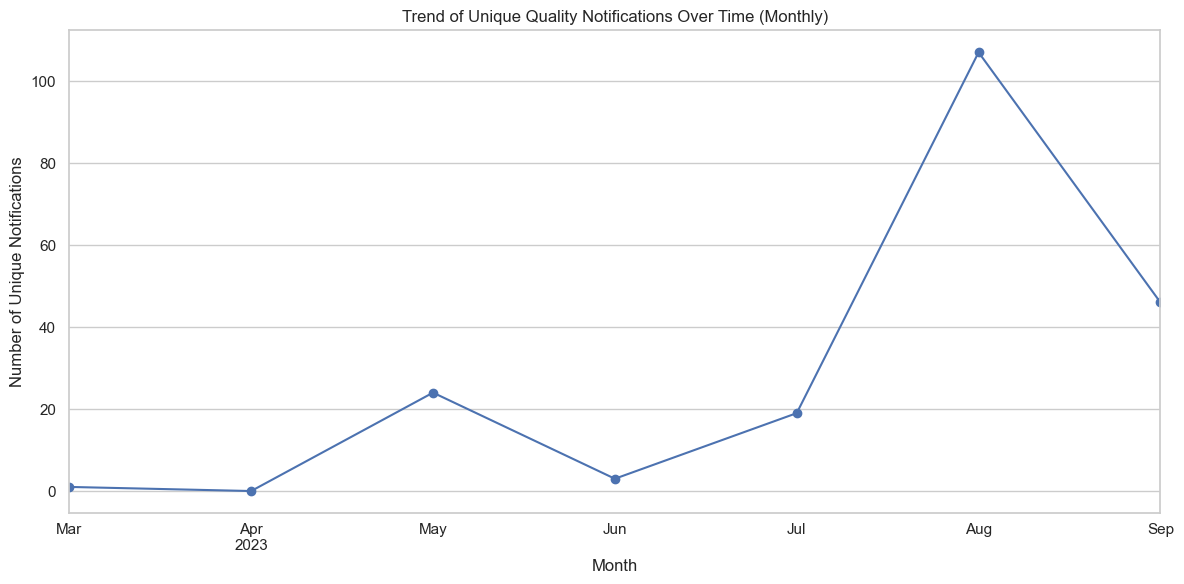


--- Finished initial analysis of df_quality_notifications ---


In [19]:
# Assume df_quality_notifications is available globally from the previous step.
# If not, it would need to be recreated.

if 'df_quality_notifications' in globals() and isinstance(df_quality_notifications, pd.DataFrame) and not df_quality_notifications.empty:
    print(f"--- Analyzing Enriched Quality Notifications (df_quality_notifications, shape: {df_quality_notifications.shape}) ---")

    # 1. Top Defects Analysis
    if 'DefectText' in df_quality_notifications.columns:
        print("\n1. Analyzing Top Defects...")
        top_defects_with_nan = df_quality_notifications['DefectText'].value_counts(dropna=False).nlargest(10)
        print("Top 10 Defects (including potential NaN count):")
        print(top_defects_with_nan)
        
        top_defects_for_plot = df_quality_notifications['DefectText'].dropna().value_counts().nlargest(10)
        if not top_defects_for_plot.empty:
            fig1, ax1 = plt.subplots(figsize=(12, 7))
            top_defects_for_plot.plot(kind='bar', ax=ax1)
            ax1.set_title('Top 10 Reported Defects')
            ax1.set_xlabel('Defect Description')
            ax1.set_ylabel('Number of Occurrences')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            plt.close(fig1)
        else:
            print("No defect text data (excluding NaN) to plot.")
    else:
        print("   Column 'DefectText' not found in df_quality_notifications.")

    # 2. Top Causes Analysis
    if 'CauseText' in df_quality_notifications.columns:
        print("\n2. Analyzing Top Causes...")
        top_causes_with_nan = df_quality_notifications['CauseText'].value_counts(dropna=False).nlargest(10)
        print("Top 10 Causes (including potential NaN count):")
        print(top_causes_with_nan)
        
        top_causes_for_plot = df_quality_notifications['CauseText'].dropna().value_counts().nlargest(10)
        if not top_causes_for_plot.empty:
            fig2, ax2 = plt.subplots(figsize=(12, 7))
            top_causes_for_plot.plot(kind='bar', ax=ax2)
            ax2.set_title('Top 10 Reported Causes for Defects')
            ax2.set_xlabel('Cause Description')
            ax2.set_ylabel('Number of Occurrences')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            plt.close(fig2)
        else:
            print("No cause text data (excluding NaN) to plot.")
    else:
        print("   Column 'CauseText' not found in df_quality_notifications.")

    # 3. Defects by Plant Analysis
    if 'PlantName' in df_quality_notifications.columns and 'DefectText' in df_quality_notifications.columns:
        print("\n3. Analyzing Defects by Plant...")
        notifications_by_plant_with_nan = df_quality_notifications['PlantName'].value_counts(dropna=False).nlargest(10)
        print("Top 10 Plants by Number of Quality Notifications (including potential NaN count):")
        print(notifications_by_plant_with_nan)
        
        notifications_by_plant_for_plot = df_quality_notifications['PlantName'].dropna().value_counts().nlargest(10)
        if not notifications_by_plant_for_plot.empty:
            fig3, ax3 = plt.subplots(figsize=(12, 7))
            notifications_by_plant_for_plot.plot(kind='bar', ax=ax3)
            ax3.set_title('Top 10 Plants by Number of Quality Notifications')
            ax3.set_xlabel('Plant Name')
            ax3.set_ylabel('Number of Notifications')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            plt.close(fig3)
        else:
            print("No PlantName data (excluding NaN) to plot for notification counts.")

        if not df_quality_notifications['DefectText'].dropna().empty:
            most_common_defect_series = df_quality_notifications['DefectText'].dropna().mode()
            if not most_common_defect_series.empty:
                most_common_defect = most_common_defect_series[0] 
                print(f"\nDistribution of the most common defect ('{most_common_defect}') across top plants:")
                
                common_defect_by_plant_for_plot = df_quality_notifications[
                    (df_quality_notifications['DefectText'] == most_common_defect) & 
                    (df_quality_notifications['PlantName'].notna())
                ]['PlantName'].value_counts().nlargest(10)
                
                if not common_defect_by_plant_for_plot.empty:
                    print(common_defect_by_plant_for_plot)
                    fig4, ax4 = plt.subplots(figsize=(12, 7))
                    common_defect_by_plant_for_plot.plot(kind='bar', ax=ax4)
                    ax4.set_title(f"Distribution of Defect '{most_common_defect}' by Plant (Top 10 Plants)")
                    ax4.set_xlabel('Plant Name')
                    ax4.set_ylabel(f"Occurrences of '{most_common_defect}'")
                    plt.xticks(rotation=45, ha='right')
                    plt.tight_layout()
                    plt.show()
                    plt.close(fig4)
                else:
                    print(f"No plant data (excluding NaN) to plot for defect '{most_common_defect}'.")
            else:
                print("Could not determine the most common defect (mode calculation was empty).")
        else:
            print("DefectText column is empty or all NaN, cannot determine most common defect.")
            
    else:
        print("   Columns 'PlantName' or 'DefectText' not found for plant-based defect analysis.")

    # 4. Defect Trends Over Time
    if 'ERDAT_header' in df_quality_notifications.columns:
        print("\n4. Analyzing Defect Trends Over Time...")
        if not pd.api.types.is_datetime64_any_dtype(df_quality_notifications['ERDAT_header']):
             df_quality_notifications['ERDAT_header'] = pd.to_datetime(df_quality_notifications['ERDAT_header'], errors='coerce')

        df_for_trends = df_quality_notifications.dropna(subset=['ERDAT_header'])
        if not df_for_trends.empty:
            monthly_defects = df_for_trends.set_index('ERDAT_header') \
                                           .resample('M')['QMNUM'] \
                                           .nunique() 
            
            if not monthly_defects.empty:
                print("Number of Unique Quality Notifications per Month:")
                print(monthly_defects)
                
                fig5, ax5 = plt.subplots(figsize=(12, 6))
                monthly_defects.plot(kind='line', marker='o', ax=ax5)
                ax5.set_title('Trend of Unique Quality Notifications Over Time (Monthly)')
                ax5.set_xlabel('Month')
                ax5.set_ylabel('Number of Unique Notifications')
                ax5.grid(True)
                plt.tight_layout()
                plt.show()
                plt.close(fig5)
            else:
                print("No data to plot for monthly defect trends after resampling (result was empty).")
        else:
            print("No valid date data in ERDAT_header to plot trends.")
    else:
        print("   Column 'ERDAT_header' not found for time trend analysis.")
        
    print("\n--- Finished initial analysis of df_quality_notifications ---")

else:
    print("DataFrame 'df_quality_notifications' is not available, is not a DataFrame, or is empty. Skipping analysis.")


In [ ]:
# Rename columns in AUFK
aufk_column_renames = {
    'AUFNR': 'AUFNR_OrderNumber',
    'ERDAT': 'CreationDate',
    'AEDAT': 'LastChangeDate',
    'KTEXT': 'ShortText',
    'WERKS': 'PlantCode',
    'ERZEIT': 'CreationTime',
    'AEZEIT': 'LastChangeTime'
}

# Apply renaming if columns exist
df_aufk.rename(columns={k: v for k, v in aufk_column_renames.items() if k in df_aufk.columns}, inplace=True)

# Clean date columns
date_columns_aufk = ['CreationDate', 'LastChangeDate', 'STDAT', 'PDAT1', 'PDAT2', 'PDAT3', 'IDAT1', 'IDAT2', 'IDAT3', 'SDATE', 'ZZBUDAT']
for col in date_columns_aufk:
    if col in df_aufk.columns:
        df_aufk[col] = (
            df_aufk[col].astype(str)
            .str.replace('.0', '', regex=False)
            .replace({'0': pd.NA, '': pd.NA})
        )
        df_aufk[col] = pd.to_datetime(df_aufk[col], format='%Y%m%d', errors='coerce')
    else:
        print(f"⚠️ Warning: Date column '{col}' not found in AUFK")

# Clean time columns
time_columns_aufk = ['CreationTime', 'LastChangeTime']
for col in time_columns_aufk:
    if col in df_aufk.columns:
        df_aufk[col] = (
            df_aufk[col].astype(str)
            .str.replace('.0', '', regex=False)
            .replace({'nan': pd.NA, '': pd.NA})
            .apply(lambda x: x.zfill(6) if pd.notna(x) else pd.NA)
        )
    else:
        print(f"⚠️ Warning: Time column '{col}' not found in AUFK")

# Preview cleaned data
print("\n✅ AUFK table after cleaning (first 5 rows):")
print(df_aufk[['AUFNR_OrderNumber', 'ShortText', 'PlantCode', 'CreationDate', 'LastChangeDate']].head().to_markdown(index=False))

# Show type summary
print("\n🔍 AUFK info:")
print(df_aufk.info())


In [ ]:


# Define the renames in a dictionary
aufk_column_renames = {
    'AUFNR': 'AUFNR_OrderNumber',
    'ERDAT': 'CreationDate',
    'AEDAT': 'LastChangeDate',
    'KTEXT': 'ShortText',
    'WERKS': 'PlantCode',
    'ERZEIT': 'CreationTime',
    'AEZEIT': 'LastChangeTime'
}

# Apply renaming only if the old column name exists
existing_columns = df_aufk.columns.tolist()
columns_to_rename = {old_name: new_name for old_name, new_name in aufk_column_renames.items() if old_name in existing_columns}
df_aufk.rename(columns=columns_to_rename, inplace=True)

# Convert date columns to datetime objects in AUFK
date_columns_aufk = ['CreationDate', 'LastChangeDate', 'STDAT', 'PDAT1', 'PDAT2', 'PDAT3', 'IDAT1', 'IDAT2', 'IDAT3', 'SDATE', 'ZZBUDAT']
for col in date_columns_aufk:
    # Check if the column exists after renaming
    if col in df_aufk.columns:
        df_aufk[col] = df_aufk[col].astype(str).str.replace('.0', '', regex=False).replace('0', pd.NA)
        df_aufk[col] = pd.to_datetime(df_aufk[col], format='%Y%m%d', errors='coerce')
    else:
        print(f"Warning: Date column '{col}' not found in df_aufk. Skipping conversion.")


# Convert time columns to string and pad with leading zeros if necessary
time_columns_aufk = ['CreationTime', 'LastChangeTime']
for col in time_columns_aufk:
    # Check if the column exists after renaming
    if col in df_aufk.columns:
        df_aufk[col] = df_aufk[col].astype(str).str.replace('.0', '', regex=False).str.zfill(6) # Pad with leading zeros to ensure 6 digits
    else:
        print(f"Warning: Time column '{col}' not found in df_aufk. Skipping conversion.")


# Display the first 5 rows with updated columns
print("\nAUFK table after cleaning (first 5 rows):")
print(df_aufk[['AUFNR_OrderNumber', 'ShortText', 'PlantCode', 'CreationDate', 'LastChangeDate']].head().to_markdown(index=False, numalign="left", stralign="left"))

# Display info to check new data types
print("\nAUFK table info after cleaning:")
print(df_aufk.info())

In [ ]:
import pandas as pd

# Rename columns for clarity
df_qmel.rename(columns={
    'QMNUM': 'NotificationNumber',
    'ERDAT': 'CreationDate',
    'MZEIT': 'CreationTime',
    'AEDAT': 'LastChangeDate',
    'AEZEIT': 'LastChangeTime',
    'QMDAT': 'NotificationDate',
    'IWERK': 'Plant',
    'AUFNR': 'ProductionOrderNumber',
    'ZZAUFNR1': 'AltProductionOrderNumber1'  # Optional, clarify use
}, inplace=True)

# Convert date columns to datetime
date_columns = ['CreationDate', 'LastChangeDate', 'NotificationDate', 'STRMN', 'BEZDT', 'PRODDAT']
for col in date_columns:
    if col in df_qmel.columns:
        df_qmel[col] = pd.to_datetime(
            df_qmel[col].astype(str).str.replace('.0', '', regex=False).replace('0', pd.NA),
            format='%Y%m%d', errors='coerce'
        )

# Convert time columns to padded strings
time_columns = ['CreationTime', 'LastChangeTime', 'ERZEIT', 'AEZEIT', 'MZEIT']
for col in time_columns:
    if col in df_qmel.columns:
        df_qmel[col] = df_qmel[col].astype(str).str.replace('.0', '', regex=False).str.zfill(6)

# Combine date and time if desired (optional)
df_qmel['CreatedTimestamp'] = pd.to_datetime(
    df_qmel['CreationDate'].astype(str) + df_qmel['CreationTime'], 
    format='%Y-%m-%d%H%M%S', errors='coerce'
) if 'CreationDate' in df_qmel.columns and 'CreationTime' in df_qmel.columns else pd.NaT

# Show preview
print("\nQMEL cleaned sample:")
print(df_qmel[['NotificationNumber', 'CreationDate', 'CreationTime', 'NotificationDate', 'ProductionOrderNumber']].head())

# Show info
print("\nData types after cleaning:")
print(df_qmel.info())


In [ ]:
# Rename columns in QMIH for consistency and clarity
df_qmih.rename(columns={
    'QMNUM': 'NotificationNumber',
    'DATAN': 'NotificationDate',
    'AUSVN': 'BreakdownStartDate',
    'AUSBS': 'BreakdownStartTime',
    'AUZTV': 'BreakdownDuration',
    'AUZTB': 'BreakdownEndTime',
    'AUSZT': 'TotalBreakdownTime',
    'IWERK': 'MaintenancePlant',
    'EQUNR': 'EquipmentNumber',
    'ILOAN': 'FunctionalLocation_General',
    'ILOAI': 'FunctionalLocation_Detail',
    'ABNUM': 'MaintenanceOrderNumber' # This might link to AUFK
}, inplace=True)

# Convert date columns to datetime objects in QMIH
date_columns_qmih = ['NotificationDate', 'BreakdownStartDate'] # Assuming AUSBS is a time, not date
for col in date_columns_qmih:
    df_qmih[col] = df_qmih[col].astype(str).str.replace('.0', '', regex=False).replace('0', pd.NA)
    df_qmih[col] = pd.to_datetime(df_qmih[col], format='%Y%m%d', errors='coerce')

# Time columns to string and pad if necessary
time_columns_qmih = ['BreakdownStartTime', 'BreakdownEndTime']
for col in time_columns_qmih:
    df_qmih[col] = df_qmih[col].astype(str).str.replace('.0', '', regex=False).str.zfill(6)

# Display the first 5 rows with updated columns
print("\nQMIH table after cleaning (first 5 rows):")
print(df_qmih[['NotificationNumber', 'MaintenancePlant', 'EquipmentNumber', 'NotificationDate', 'BreakdownStartDate', 'TotalBreakdownTime']].head().to_markdown(index=False, numalign="left", stralign="left"))

# Display info to check new data types
print("\nQMIH table info after cleaning:")
print(df_qmih.info())

In [ ]:
# Rename columns in QMFE for consistency and clarity
df_qmfe.rename(columns={
    'QMNUM': 'NotificationNumber',
    'FENUM': 'ItemNumber',
    'FEGRP': 'DefectGroup',
    'FECOD': 'DefectCode'
}, inplace=True)

# QMFE does not appear to have direct date columns that require conversion,
# but let's ensure numeric columns are appropriate types.
# For example, ItemNumber should be integer
df_qmfe['ItemNumber'] = pd.to_numeric(df_qmfe['ItemNumber'], errors='coerce').astype('Int64') # Using Int64 to allow NA

# Display the first 5 rows with updated columns
print("\nQMFE table after cleaning (first 5 rows):")
print(df_qmfe[['NotificationNumber', 'ItemNumber', 'DefectGroup', 'DefectCode']].head().to_markdown(index=False, numalign="left", stralign="left"))

# Display info to check new data types
print("\nQMFE table info after cleaning:")
print(df_qmfe.info())

In [ ]:
# Rename columns in QMUR for consistency and clarity
df_qmur.rename(columns={
    'QMNUM': 'NotificationNumber',
    'FENUM': 'DefectItemNumber',
    'URNUM': 'CauseItemNumber',
    'URTXT': 'CauseDescription',
    'URKAT': 'CauseCategory',
    'URGRP': 'CauseGroup',
    'URCOD': 'CauseCode',
    'ERDAT': 'CreationDate',
    'AEDAT': 'LastChangeDate',
    'ERZEIT': 'CreationTime',
    'AEZEIT': 'LastChangeTime'
}, inplace=True)

# Convert date columns to datetime objects in QMUR
date_columns_qmur = ['CreationDate', 'LastChangeDate']
for col in date_columns_qmur:
    df_qmur[col] = df_qmur[col].astype(str).str.replace('.0', '', regex=False).replace('0', pd.NA)
    df_qmur[col] = pd.to_datetime(df_qmur[col], format='%Y%m%d', errors='coerce')

# Convert time columns to string and pad if necessary
time_columns_qmur = ['CreationTime', 'LastChangeTime']
for col in time_columns_qmur:
    df_qmur[col] = df_qmur[col].astype(str).str.replace('.0', '', regex=False).str.zfill(6)

# Display the first 5 rows with updated columns
print("\nQMUR table after cleaning (first 5 rows):")
print(df_qmur[['NotificationNumber', 'DefectItemNumber', 'CauseItemNumber', 'CauseDescription', 'CauseCode', 'CreationDate']].head().to_markdown(index=False, numalign="left", stralign="left"))

# Display info to check new data types
print("\nQMUR table info after cleaning:")
print(df_qmur.info())

In [ ]:
# Rename columns in QPCT for consistency and clarity
df_qpct.rename(columns={
    'KATALOGART': 'CatalogType',
    'CODEGRUPPE': 'CodeGroup',
    'KURZTEXT': 'ShortText_CodeGroup',
    'LTEXTV': 'LongText_CodeGroup',
    'SPRACHE': 'Language'
}, inplace=True)

# No date columns to convert in QPCT.
# Ensure relevant identifier columns are of appropriate type (e.g., object for codes/text)
df_qpct['CodeGroup'] = df_qpct['CodeGroup'].astype(str)

# Display the first 5 rows with updated columns
print("\nQPCT table after cleaning (first 5 rows):")
print(df_qpct[['CatalogType', 'CodeGroup', 'ShortText_CodeGroup', 'Language']].head().to_markdown(index=False, numalign="left", stralign="left"))

# Display info to check new data types
print("\nQPCT table info after cleaning:")
print(df_qpct.info())

In [ ]:
# Rename columns in QPGT for consistency and clarity
df_qpgt.rename(columns={
    'KATALOGART': 'CatalogType',
    'CODEGRUPPE': 'CodeGroup',
    'KURZTEXT': 'ShortText_Code',
    'LTEXTV': 'LongText_Code',
    'SPRACHE': 'Language'
}, inplace=True)

# No date columns to convert in QPGT.
# Ensure relevant identifier columns are of appropriate type (e.g., object for codes/text)
df_qpgt['CodeGroup'] = df_qpgt['CodeGroup'].astype(str)

# Display the first 5 rows with updated columns
print("\nQPGT table after cleaning (first 5 rows):")
print(df_qpgt[['CatalogType', 'CodeGroup', 'ShortText_Code', 'Language']].head().to_markdown(index=False, numalign="left", stralign="left"))

# Display info to check new data types
print("\nQPGT table info after cleaning:")
print(df_qpgt.info())

In [ ]:
# Rename columns in CRHD_v1 for consistency and clarity
df_crhd_v1.rename(columns={
    'OBJID': 'WorkCenter_ObjectID',
    'ARBPL': 'WorkCenter_ID',
    'WERKS': 'PlantCode',
    'KTEXT': 'WorkCenter_Description',
    'SPRAS': 'Language'
}, inplace=True)

# No date columns to convert. Ensure relevant identifier columns are of appropriate type.
df_crhd_v1['WorkCenter_ID'] = df_crhd_v1['WorkCenter_ID'].astype(str)
df_crhd_v1['PlantCode'] = df_crhd_v1['PlantCode'].astype(str)

# Display the first 5 rows with updated columns
print("\nCRHD_v1 table after cleaning (first 5 rows):")
print(df_crhd_v1[['WorkCenter_ID', 'PlantCode', 'WorkCenter_Description', 'Language']].head().to_markdown(index=False, numalign="left", stralign="left"))

# Display info to check new data types
print("\nCRHD_v1 table info after cleaning:")
print(df_crhd_v1.info())

In [ ]:
# Rename columns in JEST for consistency and clarity
df_jest.rename(columns={
    'OBJNR': 'ObjectNumber_JEST', # Renaming to differentiate from other OBJNRs
    'STAT': 'Status_Code',
    'INACT': 'Inactive_Indicator'
}, inplace=True)

# No date columns to convert. Ensure relevant identifier columns are of appropriate type.
df_jest['ObjectNumber_JEST'] = df_jest['ObjectNumber_JEST'].astype(str)
df_jest['Status_Code'] = df_jest['Status_Code'].astype(str)
# Convert 'Inactive_Indicator' to boolean or appropriate numeric if needed
df_jest['Inactive_Indicator'] = df_jest['Inactive_Indicator'].replace({'1': True, 1: True, '0': False, 0: False, None: False}).astype(bool)


# Display the first 5 rows with updated columns
print("\nJEST table after cleaning (first 5 rows):")
print(df_jest[['ObjectNumber_JEST', 'Status_Code', 'Inactive_Indicator']].head().to_markdown(index=False, numalign="left", stralign="left"))

# Display info to check new data types
print("\nJEST table info after cleaning:")
print(df_jest.info())

In [ ]:
# Rename columns in QPCD for consistency and clarity
df_qpcd.rename(columns={
    'KATALOGART': 'CatalogType',
    'CODEGRUPPE': 'CodeGroup',
    'CODE': 'Code',
    'GUELTIGAB': 'ValidFromDate',
    'E_DATUM': 'CreationDate',
    'A_DATUM': 'LastChangeDate'
}, inplace=True)

# Convert date columns to datetime objects in QPCD
date_columns_qpcd = ['ValidFromDate', 'CreationDate', 'LastChangeDate']
for col in date_columns_qpcd:
    df_qpcd[col] = df_qpcd[col].astype(str).str.replace('.0', '', regex=False).replace('0', pd.NA)
    df_qpcd[col] = pd.to_datetime(df_qpcd[col], format='%Y%m%d', errors='coerce')

# Ensure code columns are string type
df_qpcd['CodeGroup'] = df_qpcd['CodeGroup'].astype(str)
df_qpcd['Code'] = df_qpcd['Code'].astype(str)

# Display the first 5 rows with updated columns
print("\nQPCD table after cleaning (first 5 rows):")
print(df_qpcd[['CatalogType', 'CodeGroup', 'Code', 'ValidFromDate']].head().to_markdown(index=False, numalign="left", stralign="left"))

# Display info to check new data types
print("\nQPCD table info after cleaning:")
print(df_qpcd.info())

In [ ]:
# Ensure AUFNR is string and zero-padded to 12 digits in all DataFrames
df_aufk['AUFNR_OrderNumber'] = df_aufk['AUFNR_OrderNumber'].astype(str).str.zfill(12)
df_afko['AUFNR'] = df_afko['AUFNR'].astype(str).str.zfill(12)
df_afpo['AUFNR'] = df_afpo['AUFNR'].astype(str).str.zfill(12)
df_aufm['AUFNR'] = df_aufm['AUFNR'].astype(str).str.zfill(12)

# Drop unnecessary or duplicate AUFNR column in AFKO if it exists
if 'AUFNR 2 Order Number' in df_afko.columns:
    df_afko.drop(columns=['AUFNR 2 Order Number'], inplace=True)

# Merge AUFK (Order Header) with AFKO (Production Order Header)
production_orders_df = pd.merge(
    df_aufk, df_afko,
    left_on='AUFNR_OrderNumber',
    right_on='AUFNR',
    how='left',
    suffixes=('_AUFK', '_AFKO')
)

# Drop redundant AUFNR if it matches AUFNR_OrderNumber
if 'AUFNR' in production_orders_df.columns and production_orders_df['AUFNR'].equals(production_orders_df['AUFNR_OrderNumber']):
    production_orders_df.drop(columns=['AUFNR'], inplace=True)

# Merge with AFPO (Production Order Item Data)
production_orders_df = pd.merge(
    production_orders_df, df_afpo,
    left_on='AUFNR_OrderNumber',
    right_on='AUFNR',
    how='left',
    suffixes=('', '_AFPO_item')
)

# Drop redundant AUFNR from AFPO if identical
if 'AUFNR' in production_orders_df.columns and production_orders_df['AUFNR'].equals(production_orders_df['AUFNR_OrderNumber']):
    production_orders_df.drop(columns=['AUFNR'], inplace=True)

# Merge with AUFM (Goods Movements)
production_orders_df = pd.merge(
    production_orders_df, df_aufm,
    left_on='AUFNR_OrderNumber',
    right_on='AUFNR',
    how='left',
    suffixes=('', '_AUFM')
)

# Drop redundant AUFNR from AUFM if identical
if 'AUFNR' in production_orders_df.columns and production_orders_df['AUFNR'].equals(production_orders_df['AUFNR_OrderNumber']):
    production_orders_df.drop(columns=['AUFNR'], inplace=True)

# Display result
print("\n✅ Merged Production Orders DataFrame (first 5 rows):")
print(production_orders_df.head().to_markdown(index=False))

print("\n📋 Merged DataFrame Info:")
print(production_orders_df.info())


In [ ]:
quality_notifications_df = pd.merge(
    df_qmel,
    df_qmfe,
    on='NotificationNumber',
    how='left',
    suffixes=('_QMEL', '_QMFE')
)

quality_notifications_df

In [ ]:
print("Step 1: Merged QMEL and QMFE. Shape:", quality_notifications_df.shape)
print("Columns after QMEL-QMFE merge:", quality_notifications_df.columns.tolist())
# print(quality_notifications_df.head().to_markdown(index=False, numalign="left", stralign="left")) # Optional: inspect intermediate result

# --- Section 2: Merge with QMUR (Causes) ---
print("\n--- Section 2: Merging with QMUR (Causes) ---")
# This step adds cause information to the quality notifications.
# It merges on both 'NotificationNumber' and an 'ItemNumber' column.
# The 'ItemNumber' column name might vary based on the previous merge, so we determine it dynamically.
item_number_col_in_merged_df = 'ItemNumber_QMFE' if 'ItemNumber_QMFE' in quality_notifications_df.columns else 'ItemNumber'

if item_number_col_in_merged_df not in quality_notifications_df.columns:
    print(f"Warning: Expected item number column '{item_number_col_in_merged_df}' not found after QMEL-QMFE merge. Please check column names.")
    # As a fallback, if 'ItemNumber' (unsuffixed) exists, use it. This assumes it's the correct one from QMFE.
    if 'ItemNumber' in quality_notifications_df.columns:
        item_number_col_in_merged_df = 'ItemNumber'
    else:
        print("Critical Warning: Cannot determine a valid ItemNumber column for merging with QMUR. This merge might fail.")


In [ ]:
quality_notifications_df = pd.merge(
    quality_notifications_df,
    df_qmur,
    left_on=['NotificationNumber', item_number_col_in_merged_df], # Using determined ItemNumber column
    right_on=['NotificationNumber', 'DefectItemNumber'],
    how='left',
    suffixes=('', '_QMUR') # Suffix for QMUR columns if they clash
)

quality_notifications_df


In [ ]:
# Drop redundant 'DefectItemNumber' from QMUR if it was suffixed and brought in
quality_notifications_df.drop(columns=['DefectItemNumber_QMUR'], inplace=True, errors='ignore')
print("Step 2: Merged with QMUR. Shape:", quality_notifications_df.shape)
print("Columns after QMUR merge:", quality_notifications_df.columns.tolist())
# print(quality_notifications_df.head().to_markdown(index=False, numalign="left", stralign="left")) # Optional: inspect intermediate result

# --- Section 3: Enrich with Code Descriptions from QPCT (Code Group Texts) and QPGT (Code Texts) ---
print("\n--- Section 3: Enriching with Code Descriptions ---")
# This is where your KeyError is most likely originating.
# We will merge multiple times with df_qpgt and df_qpct to add descriptive text
# for various codes (Notification Type, Defect Group, Defect Code, Cause Group, Cause Code).

# 3.1 Merge for QMEL's QMART (Notification Type) description from QPGT
print("\n--- 3.1: Enriching Notification Type Description ---")
# Filter QPGT for CatalogType 'Q' (Quality Notification Types).
# Then select 'Code' and 'ShortText_Code' for merging.
# The error "['Code'] not in index" means df_qpgt does not have a column named 'Code'
# when you try to access it like `qpgt_catalog_q[['Code', 'ShortText_Code']]`.
# Double-check the exact column names in df_qpgt using the initial print statement.
qpgt_catalog_q = df_qpgt[df_qpgt['CatalogType'] == 'Q'].copy() # Use .copy() to avoid SettingWithCopyWarning
print("Columns in qpgt_catalog_q (subset of df_qpgt):", qpgt_catalog_q.columns.tolist())
qpgt_qmart_subset = qpgt_catalog_q[ 'ShortText_Code'] # <-- Error likely here if 'Code' is missing


In [ ]:
quality_notifications_df = pd.merge(
    quality_notifications_df,
    qpgt_qmart_subset,
    left_on='QMART', # Notification Type from QMEL
#    Assuming QMART maps to 'Code' in QPGT for CatalogType 'Q'
    how='left',
    suffixes=('', '_QMART_Desc')
)



In [ ]:
qmel_qm_qpgt = df_qpgt[(df_qpgt['CatalogType'] == 'Q')]
print("Columns in qmel_qm_qpgt:", qmel_qm_qpgt.columns)

In [ ]:
# Rename columns in QMIH for consistency and clarity
# (Already done in Cleaning step 1.7)
# df_qmih.rename(columns={
#     'QMNUM': 'NotificationNumber_Maint',
#     'DATAN': 'NotificationDate',
#     'AUSVN': 'BreakdownStartDate',
#     'AUZTV': 'BreakdownDuration',
#     'IWERK': 'MaintenancePlant',
#     'EQUNR': 'EquipmentNumber',
#     'ILOAN': 'FunctionalLocation_General',
#     'ABNUM': 'MaintenanceOrderNumber'
# }, inplace=True)

# Link QMIH to production orders if 'MaintenanceOrderNumber' (ABNUM) matches a production order number.
# Ensure 'MaintenanceOrderNumber' in QMIH is string and padded for consistent merging
df_qmih['MaintenanceOrderNumber'] = df_qmih['MaintenanceOrderNumber'].astype(str).str.zfill(12)

maintenance_notifications_df = pd.merge(df_qmih, production_orders_df[['AUFNR_OrderNumber', 'ShortText_AUFK', 'PlantCode_AUFK', 'CreationDate_AUFK']],
                                        left_on='MaintenanceOrderNumber',
                                        right_on='AUFNR_OrderNumber',
                                        how='left',
                                        suffixes=('', '_ProdOrder_Maint'))

# Drop the redundant 'AUFNR_OrderNumber_ProdOrder_Maint'
if 'AUFNR_OrderNumber_ProdOrder_Maint' in maintenance_notifications_df.columns:
    maintenance_notifications_df.drop(columns=['AUFNR_OrderNumber_ProdOrder_Maint'], inplace=True)

print("\nMerged Maintenance Notifications DataFrame (first 5 rows):")
print(maintenance_notifications_df[['NotificationNumber_Maint', 'MaintenancePlant', 'EquipmentNumber', 'NotificationDate', 'MaintenanceOrderNumber', 'ShortText_AUFK']].head().to_markdown(index=False, numalign="left", stralign="left"))

print("\nMerged Maintenance Notifications DataFrame info:")
print(maintenance_notifications_df.info())

In [ ]:
# JEST 'ObjectNumber_JEST' needs to be padded with leading zeros for consistency with AUFNR and QMNUM
# Assuming production order numbers (AUFNR) are 12 digits and notification numbers (QMNUM) are 12 digits.
df_jest['ObjectNumber_JEST_Padded'] = df_jest['ObjectNumber_JEST'].astype(str).str.zfill(12)

# Merge JEST with Production Orders
# We will use left merge to keep all production orders and add their statuses
production_orders_with_status_df = pd.merge(production_orders_df, df_jest,
                                            left_on='AUFNR_OrderNumber',
                                            right_on='ObjectNumber_JEST_Padded',
                                            how='left',
                                            suffixes=('', '_Status'))

# Drop redundant ObjectNumber_JEST_Padded_Status if it exists
if 'ObjectNumber_JEST_Padded_Status' in production_orders_with_status_df.columns:
    production_orders_with_status_df.drop(columns=['ObjectNumber_JEST_Padded_Status'], inplace=True)


# Merge JEST with Quality Notifications
quality_notifications_with_status_df = pd.merge(quality_notifications_df, df_jest,
                                                left_on='NotificationNumber',
                                                right_on='ObjectNumber_JEST_Padded',
                                                how='left',
                                                suffixes=('', '_Status'))

# Drop redundant ObjectNumber_JEST_Padded_Status if it exists
if 'ObjectNumber_JEST_Padded_Status' in quality_notifications_with_status_df.columns:
    quality_notifications_with_status_df.drop(columns=['ObjectNumber_JEST_Padded_Status'], inplace=True)

# Merge JEST with Maintenance Notifications
maintenance_notifications_with_status_df = pd.merge(maintenance_notifications_df, df_jest,
                                                    left_on='NotificationNumber_Maint',
                                                    right_on='ObjectNumber_JEST_Padded',
                                                    how='left',
                                                    suffixes=('', '_Status'))

# Drop redundant ObjectNumber_JEST_Padded_Status if it exists
if 'ObjectNumber_JEST_Padded_Status' in maintenance_notifications_with_status_df.columns:
    maintenance_notifications_with_status_df.drop(columns=['ObjectNumber_JEST_Padded_Status'], inplace=True)


print("\nProduction Orders with Status (first 5 rows):")
print(production_orders_with_status_df[['AUFNR_OrderNumber', 'ShortText_AUFK', 'Status_Code', 'Inactive_Indicator']].head().to_markdown(index=False, numalign="left", stralign="left"))
print("\nQuality Notifications with Status (first 5 rows):")
print(quality_notifications_with_status_df[['NotificationNumber', 'NotificationTypeDescription', 'Status_Code', 'Inactive_Indicator']].head().to_markdown(index=False, numalign="left", stralign="left"))
print("\nMaintenance Notifications with Status (first 5 rows):")
print(maintenance_notifications_with_status_df[['NotificationNumber_Maint', 'EquipmentNumber', 'Status_Code', 'Inactive_Indicator']].head().to_markdown(index=False, numalign="left", stralign="left"))